In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For customizing the suabplots spacing
import pandas as pd
import polars as pl
import os

In [2]:
from sklearn.decomposition import FastICA
import scipy
import scipy.signal as scsig

In [3]:
from laser_dataset import LaserDataInteractor
from synchronization import Synchronizer
from data_preprocessing import process_laser_data

## Steps for synchronization
- (0) Load the metadata (Versuchstabelle) -> to identify the file names (soundbook, QASS)
- (1) Load the QASS signals 
    - synch signal = Ch.4
    - Zeor-mean and normalization computed in the synchornizer class
- (2) Load and process the Dewetron signal (to compensate the different sampling rate)
    - (2.1) Load + zero-mean & normalize
    - (2.2) Linear interpolation
- (3) Cross-correlate the interpolated Dewetron signal and the IDMT data
- (4) Identify the delay (i.e. peak)

## (0) Load the meta data (Versuchstabelle) -> for file names

In [4]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="C:G, I, R,S",
    nrows=71,
    decimal=','
)

In [5]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_qass = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS'

# Example trial
dataID = 20
row = dataID - 1 #22, 27, 30, 39, 40, 43, 44 -> negative delay
fname_dew = metadf['DEWETRON'][row]
qassNo = str(metadf['QASS'][row]).zfill(3)
print(qassNo)

064


## (1) Load the QASS data

In [6]:
# Synchsignal
synch = Synchronizer()
# Change the sampling frequency (NEW: 24/02/22)
synch.fs_izfp = 97.0*10**3 #[Hz]
# Load the derivative of the synch signal (Ch.4)
t_izfp, s_izfp = synch.load_qass(path_qass, qassNo)

In [7]:
#----- Sensor signals
# params
fs_qass = 6.25*10**6 # [Hz]
f_range_ab = [5*10**3, 400*10**3] # [Hz]
w = 1.0*10**-3 #[s], smoothing duration

interactor = LaserDataInteractor()
interactor.df = metadf
interactor.df_row = fname_dew
# load the raw data
#s1 = interactor.load(chNo=1, path=path_qass)
#s2 = interactor.load(chNo=2, path=path_qass)
s3 = interactor.load(chNo=3, path=path_qass)
t = 1/fs_qass* np.arange(0, len(s3))

#---- Processing the sensor signals
s3 = process_laser_data(s3, f_range_ab, 1/fs_qass, w)

In [8]:
#s1 = interactor.load(chNo=1, path=path_qass)
#s2 = interactor.load(chNo=2, path=path_qass)

## (2) Load the Dewetron synch derivative signal

In [9]:
# Load the derivative of the synch signal of the Dewetron
t_dew, s_dew = synch.load_dew(path_dew, fname_dew, sigtypes=['Sync/Derivative_V/s'])
# Zero-mean and normalize
s_dew = s_dew - s_dew.mean()
s_dew = s_dew / np.abs(s_dew).max()


_, s2_dew = synch.load_dew(path_dew, fname_dew)

## (3) Synchronization

In [10]:
# # Intepolation -> duration = [0.0, T4]s
t_interp, s_interp = synch.interpolate(t_dew, s_dew, t_izfp, synch.fs_izfp)
# (4) Identify the delay
delay, _, corr, tau = synch.identify_delay(s_interp, s_izfp, synch.fs_izfp, ret_corr=True)

print(delay)

Synchronizer: returning the correlation results
0.005268041


## (4) Delay correction

In [11]:
trial_df = metadf[metadf['DEWETRON']==fname_dew].reset_index(drop=True)

t_start_cam = trial_df['tstart [s]'].item()
t_end_cam = trial_df['tend [s]'].item()
t_start_qass = t_start_cam - delay
t_end_qass = t_end_cam - delay

print(f't_start: HD camera = {t_start_cam}s, QASS = {t_start_qass}s')
print(f't_end: HD camera = {t_end_cam}s, QASS = {t_end_qass}s')

t_start: HD camera = 0.2508s, QASS = 0.24553195900000002s
t_end: HD camera = 1.057s, QASS = 1.051731959s


## (5) Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


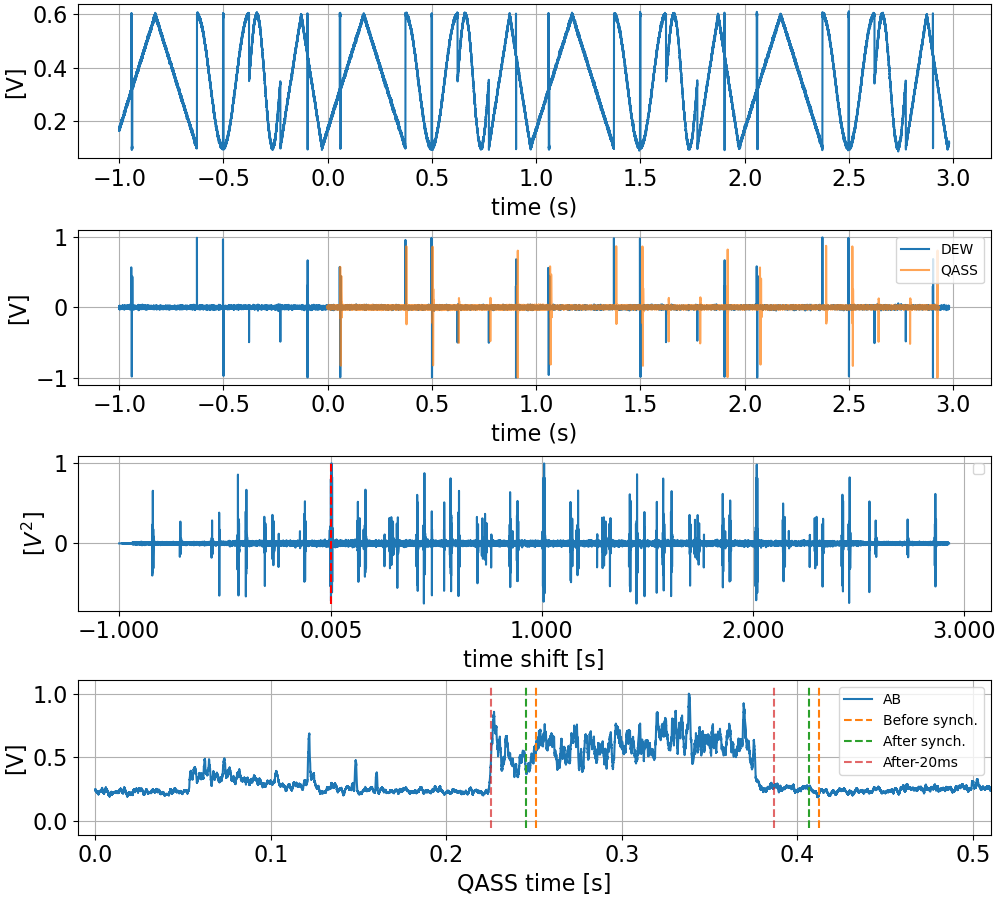

In [16]:
# Plot:
# (a) Actual synchsignal
# (b) Derivative of the synchsignal: Dewetron vs QASS
# (c) Synchronization results: cross correlation 
# (d) Processed sensor signal

%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(10, 9.0), layout='constrained') #10, 9
axs = fig.subplot_mosaic([
    ["synch_signal"],
    ["synch_deriv"],
    ["cross_corr"],
    ["qass_AB"]
])
# Spacing
gs1 = gridspec.GridSpec(3, 1)
gs1.update(wspace=0.0, hspace=0.15)

# Axis labels
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['axes.grid'] = True
plt.rcParams['legend.loc'] = 'upper right'

#plt.suptitle(f'Trial: {fname_dew}')
#plt.subplots_adjust(hspace=0.6) # more spacing between rows

# (a) Synchsignal
#axs["synch_signal"].set_title('(a) Synchsignal')
axs["synch_signal"].plot(t_dew, s2_dew, color='C0')
axs["synch_signal"].set_xlabel("time (s)")
axs["synch_signal"].set_ylabel("[V]")

# (b) 1st derivative of Dewetron signals
#axs["synch_deriv"].set_title('(b) Derivataive')
axs["synch_deriv"].plot(t_dew, s_dew, color='C0', label='DEW')
axs["synch_deriv"].plot(t_izfp, s_izfp, color='C1', alpha=0.7, label='QASS')
axs["synch_deriv"].set_xlabel("time (s)")
axs["synch_deriv"].set_ylabel("[V]")
axs["synch_deriv"].legend()

# (c) Cross-correlation results
_corr = corr/np.abs(corr).max()
#axs["cross_corr"].set_title(f'(c) Cross correlation: {round(delay*10**3, 3)}ms delay')
axs["cross_corr"].plot(tau, _corr)
peaks = delay
axs["cross_corr"].vlines(x=peaks, ymin=_corr.min(), ymax=_corr.max(), linestyles='--', color='r')
axs["cross_corr"].set_xlabel('time shift [s]')
axs["cross_corr"].set_ylabel(r"[$V^2$]")
axs["cross_corr"].legend(loc='upper right')
xticks = np.sort(np.concatenate((np.array([peaks]), np.array([-1.0, 1.0, 2.0, 3.0]))))
axs["cross_corr"].set_xticks(xticks)

# (d) QASS Ch.3
#axs["qass_AB"].set_title('(d) Processed QASS Ch.3 (AB) and patchs')
axs["qass_AB"].plot(t, s3/np.abs(s3).max(), label='AB')
axs["qass_AB"].vlines(
    x=np.linspace(t_start_cam, t_end_cam, 6), 
    ymin=-0.05, ymax=1.05, 
    linestyle='--', color='C1', label='Before synch.'
)
axs["qass_AB"].vlines(
    x=np.linspace(t_start_qass, t_end_qass, 6),#[t_start_qass, t_end_qass], 
    ymin=-0.05, ymax=1.05, 
    linestyle='--', color='C2', label='After synch.'
)
axs["qass_AB"].vlines(
    x=np.linspace(t_start_qass, t_end_qass, 6) - 20*10**-3,
    ymin=-0.05, ymax=1.05, 
    alpha=0.7, linestyle='--', color='C3', label='After-20ms'
)
axs["qass_AB"].set_xlim(left=-0.01, right=0.51)
axs["qass_AB"].set_xlabel('QASS time [s]')
axs["qass_AB"].set_ylabel('[V]')
axs["qass_AB"].legend()

plt.show()

In [14]:
plt.close('all')

## Plot the frequency response of the QASS synchsignal

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(7, 9), layout='constrained')
axs = fig.subplot_mosaic([
    ["signal", "signal"],
    ["signal_deriv", "signal_deriv"],
    ["magnitude", "log_magnitude"],
    ["phase", "angle"]
])

plt.rcParams['axes.grid'] = True
plt.rcParams['legend.loc'] = 'upper right'

# plot Dewetron synch signal
axs["signal"].set_title(f'Signal {fname_dew}')
axs["signal"].plot(t_dew, s2_dew, color='C0')
axs["signal_deriv"].set_xlabel("Time (s)")
axs["signal_deriv"].set_ylabel("Amplitude")

# plot 1st derivative of Dewetron signals
axs["signal_deriv"].set_title('Derivataive')
axs["signal_deriv"].plot(t_dew, s_dew, color='C0', label='DEW')
axs["signal_deriv"].plot(t_izfp, s_izfp, color='C1', alpha=0.7, label='QASS')
axs["signal_deriv"].set_xlabel("Time (s)")
axs["signal_deriv"].set_ylabel("Amplitude")
axs["signal_deriv"].legend()

# plot different spectrum types:
axs["magnitude"].set_title("Magnitude Spectrum")
axs["magnitude"].magnitude_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["magnitude"].magnitude_spectrum(s_izfp, Fs=synch.fs_izfp, color='C1', alpha=0.7, label='QASS')

axs["log_magnitude"].set_title("Log. Magnitude Spectrum")
axs["log_magnitude"].magnitude_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW', scale='dB')
axs["log_magnitude"].magnitude_spectrum(s_izfp, Fs=synch.fs_izfp, color='C1', alpha=0.7, label='QASS', scale='dB')

axs["phase"].set_title("Phase Spectrum ")
axs["phase"].phase_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["phase"].phase_spectrum(s_izfp, Fs=synch.fs_izfp, color='C1', alpha=0.7, label='QASS')

axs["angle"].set_title("Angle Spectrum")
axs["angle"].angle_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["angle"].angle_spectrum(s_izfp, Fs=synch.fs_izfp, color='C1', alpha=0.7, label='QASS')

#fig.legend(labels=['DEW', 'QASS'])
plt.show()

In [ ]:
#plt.close('all')

In [ ]:
raise ValueError('Stop!')

## Filter design

In [ ]:
### Low-pass

# (1) Construct an analog filter (Butterworth) 
filts_lp = scsig.lti(*scsig.butter(N=4, Wn=2*np.pi*5*10**3, btype='lowpass', analog=True))

# (2) Convert (1) into a digital filter using bilinear transform
filtz_lp = scsig.lti(*scsig.bilinear(b=filts_lp.num, a=filts_lp.den, fs=synch.fs_izfp))
# (3) Compute the freq. responses: w = angular freq., h = freq response
wz_lp, hz_lp = scsig.freqz(filtz_lp.num, filtz_lp.den, worN=int(len(s_izfp)/2)) # = freq. response of (2), i.e. digital
#ws, hs = scsig.freqs(filts.num, filts.den, worN=synch.fs_izfp*wz) # = freq. response of (1), i.e. analog 

In [ ]:
### High-pass

# (1) Construct an analog filter (Butterworth) 
filts_hp = scsig.lti(*scsig.butter(N=4, Wn=2*np.pi*40*10**3, btype='highpass', analog=True))

# (2) Convert (1) into a digital filter using bilinear transform
filtz_hp = scsig.lti(*scsig.bilinear(b=filts_hp.num, a=filts_hp.den, fs=synch.fs_izfp))
# (3) Compute the freq. responses: w = angular freq., h = freq response
wz_hp, hz_hp = scsig.freqz(filtz_hp.num, filtz_hp.den, worN=int(len(s_izfp)/2)) # = freq. response of (2), i.e. digital

In [ ]:
# Plot
%matplotlib inline

plt.semilogx(
    0.5* wz_lp*synch.fs_izfp/np.pi, 
    20*np.log10(np.abs(hz_lp).clip(1e-15)),
    label='LP', 
    #scale='dB'
)
plt.semilogx(
    0.5* wz_lp*synch.fs_izfp/(np.pi), 
    20*np.log10(np.abs(hz_hp).clip(1e-15)),
    label='HP', 
    #scale='dB'
)

plt.semilogx(
    0.5* wz_lp*synch.fs_izfp/(np.pi), 
    20*np.log10(np.abs(hz_lp + hz_hp).clip(1e-15)),
    label='Band-stop', 
    #scale='dB'
)

plt.legend(loc='upper left')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

In [ ]:
# Band-stop
hz = hz_lp# + hz_hp
wz = np.copy(wz_lp)

In [ ]:
hz_both = np.concatenate((hz, np.flip(hz)))
#hs_both = np.concatenate((hs, np.flip(hs)))
wz_both = np.concatenate((0.5*wz, 0.5*np.pi+0.5*wz))

In [ ]:
plt.plot(
    wz_both*synch.fs_izfp/(np.pi),  
    20*np.log10(np.abs(hs_both).clip(1e-15)),
    label='analog', 
    #scale='dB'
)
plt.plot(
    wz_both*synch.fs_izfp/(np.pi),  
    20*np.log10(np.abs(hz_both).clip(1e-15)),
    label='digital', 
    #scale='dB'
)
plt.title('Filter response (both positive and negative freq.)')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [dB]')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Sanity check
print(f'True fs = {synch.fs_izfp}Hz')
print(f'fs based on wz_both = {(wz_both*synch.fs_izfp/(np.pi))[-1]}Hz')

## High-passing the synch signal

In [ ]:
sp_izfp = np.fft.fft(s_izfp)
sp_izfp_lp = hz_both* sp_izfp

In [ ]:
freq = synch.fs_izfp* np.fft.fftshift(np.fft.fftfreq(len(sp_izfp)))

In [ ]:
%matplotlib inline

fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(
    0.5* synch.fs_dew*np.fft.fftshift(np.fft.fftfreq(len(s_dew))),  
    np.fft.fftshift(np.abs(np.fft.fft(s_dew))),
    #20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(s_dew)))),
    label='DEW', 
    #scale='dB'
)
ax0.plot(
    freq,  
    np.fft.fftshift(np.abs(sp_izfp_lp)),
    #20*np.log10(np.fft.fftshift(np.abs(sp_izfp_lp))),
    label='filtered', 
    alpha=0.7
    #scale='dB'
)
ax0.set_title('Freq. response DEW vs QASS filt')
ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('PSD [dB]')
ax0.legend(loc='upper right')
#ax0.set_xlim(left=-550, right=550)


ax1.plot(
    freq,  
    np.fft.fftshift(np.abs(sp_izfp)),
    #20*np.log10(np.fft.fftshift(np.abs(sp_izfp))),
    label='raw', 
    #scale='dB'
)
ax1.plot(
    freq,  
    np.fft.fftshift(np.abs(sp_izfp_lp)),
    #20*np.log10(np.fft.fftshift(np.abs(sp_izfp_lp))),
    label='filtered', 
    alpha=0.7
    #scale='dB'
)
ax1.set_title('Freq. response QASS: raw vs filt')
ax1.set_xlabel('f [Hz]')
ax1.set_ylabel('PSD [dB]')
ax1.legend(loc='upper right')
#ax1.set_xlim(left=-550, right=550)


plt.show()

## IFFT

In [ ]:
s_izfp_lp = np.fft.ifft(sp_izfp_lp).real
s_izfp_lp = s_izfp_lp / np.abs(s_izfp_lp).max()

In [ ]:
%matplotlib widget
#%matplotlib inline

fig, (ax0, ax1) = plt.subplots(nrows=2)
plt.suptitle(f'Synchsignals: {fname_dew}')
plt.subplots_adjust(hspace=0.6) # more spacing between rows

# Raw
ax0.plot(t_dew, s_dew, label='DEW deriv')
ax0.plot(t_izfp, s_izfp, alpha=0.7, label='QASS')
ax0.set_xlabel('trigger time [s]')
ax0.legend(loc='upper right')
ax0.set_xlim(left=0.1, right=0.12)
ax0.grid(True)

# LP
ax1.plot(t_dew, s_dew, label='DEW deriv')
ax1.plot(t_izfp, s_izfp_lp, alpha=0.7, label='QASS HP: >200Hz')
ax1.set_xlabel('trigger time [s]')
ax1.legend(loc='upper right')
ax1.set_xlim(left=0.1, right=0.12)
ax1.grid(True)